In [22]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [23]:
import pennylane as qml
from pennylane import qchem

In [24]:
from pennylane import numpy as np

# atomic symbols defining the molecule
symbols = ['Li', 'H']

# list to store energies
energies = []

# set up a loop to change bond length
r_range = np.arange(0.5, 6.0, 0.25)

# keeps track of points in the potential energy surface
pes_point = 0

In [25]:
basis_set = "sto-3g"

electrons = 4
orbitals = 12
core, active = qchem.active_space(electrons, orbitals, active_electrons=4, active_orbitals=6)
print("List of core orbitals: {:}".format(core))
print("List of active orbitals: {:}".format(active))
print("Number of qubits: {:}".format(2 * len(active)))


List of core orbitals: []
List of active orbitals: [0, 1, 2, 3, 4, 5]
Number of qubits: 12


In [26]:
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 2.8])

H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, active_electrons=4,
    active_orbitals=4)
print("Number of qubits: {:}".format(qubits))
print("Qubit Hamiltonian")
print(H)

Number of qubits: 8
Qubit Hamiltonian
  (-4.90327746097824) [I0]
+ (0.03683081479899247) [Z6]
+ (0.03683081479899253) [Z7]
+ (0.048153519945122264) [Z4]
+ (0.048153519945122264) [Z5]
+ (0.21600850456101) [Z3]
+ (0.21600850456101006) [Z2]
+ (1.3867027279545123) [Z0]
+ (1.3867027279545123) [Z1]
+ (-0.029480949421114212) [Y0 Y2]
+ (-0.029480949421114212) [X0 X2]
+ (-0.0014799323436687488) [Y3 Y5]
+ (-0.0014799323436687488) [X3 X5]
+ (0.001866380802828554) [Y1 Y3]
+ (0.001866380802828554) [X1 X3]
+ (0.01166085285519047) [Y2 Y4]
+ (0.01166085285519047) [X2 X4]
+ (0.053806396102079115) [Z2 Z4]
+ (0.053806396102079115) [Z3 Z5]
+ (0.05680280166271322) [Z2 Z5]
+ (0.05680280166271322) [Z3 Z4]
+ (0.0602317906576606) [Z4 Z6]
+ (0.0602317906576606) [Z5 Z7]
+ (0.06299161750284535) [Z2 Z6]
+ (0.06299161750284535) [Z3 Z7]
+ (0.06901498399948428) [Z2 Z7]
+ (0.06901498399948428) [Z3 Z6]
+ (0.07056343830239953) [Z4 Z7]
+ (0.07056343830239953) [Z5 Z6]
+ (0.07823636351741459) [Z6 Z7]
+ (0.08473958464283764

In [27]:



for r in r_range:
    # Change only the z coordinate of one atom
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])

    # Obtain the qubit Hamiltonian 
    H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, active_electrons=4,
    active_orbitals=4)
    
    hf_state = qchem.hf_state(4, qubits)
    singles, doubles = qchem.excitations(4, qubits)
    mergedexcitations = []
    mergedexcitations.extend(singles)
    mergedexcitations.extend(doubles)
    
    #print(f"Total number of excitations = {len(singles) + len(doubles)}")
    #print(doubles)
    #print(qubits)

    # define the device, optimizer and circuit
    dev = qml.device("default.qubit", wires=qubits)
    opt = qml.GradientDescentOptimizer(stepsize=0.4)

    @qml.qnode(dev)
    def circuit(parameters, excitations):
        # Prepare the HF state
        qml.BasisState(hf_state, wires=range(qubits))
        
        for i, excitation in enumerate(excitations):
            
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)

        return qml.expval(H)  # we are interested in minimizing this expectation value

    # initialize the gate parameters
    params = np.zeros(len(doubles), requires_grad=True)
    
    # initialize with converged parameters from previous point
    if pes_point > 0:
        params = params_old

    prev_energy = 0.0
    for n in range(50):
        # perform optimization step
        #print("Optimization step {n}")
        params, energy = opt.step_and_cost(circuit, params, excitations=doubles)

        if np.abs(energy - prev_energy) < 1e-6:
            break
        prev_energy = energy

    # store the converged parameters
    params_old = params
    pes_point = pes_point + 1

    energies.append(energy)
    print("r=", r)

/opt/conda/envs/pennylane/lib/python3.9/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


r= 0.5
r= 0.75
r= 1.0
r= 1.25
r= 1.5
r= 1.75
r= 2.0
r= 2.25
r= 2.5
r= 2.75
r= 3.0
r= 3.25
r= 3.5
r= 3.75
r= 4.0
r= 4.25
r= 4.5
r= 4.75
r= 5.0
r= 5.25
r= 5.5
r= 5.75


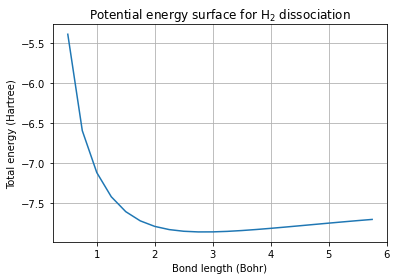

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(r_range, energies)

ax.set(
    xlabel="Bond length (Bohr)",
    ylabel="Total energy (Hartree)",
    title="Potential energy surface for H$_2$ dissociation",
)
ax.grid()
plt.show()

In [29]:
# equilibrium energy
e_eq = min(energies)
# energy when atoms are far apart
e_dis = energies[-1]

# Bond dissociation energy
bond_energy = e_dis - e_eq

# Equilibrium bond length
idx = energies.index(e_eq)
bond_length = r_range[idx]

print(f"The equilibrium bond length is {bond_length:.1f} Bohrs")
print(f"The bond dissociation energy is {bond_energy:.6f} Hartrees")

The equilibrium bond length is 2.8 Bohrs
The bond dissociation energy is 0.156615 Hartrees
